# Develop

Some basics of Keras and tensorflow I have learned with the help of these notebooks by: [siimondele](https://www.kaggle.com/sdelecourt/cnn-with-keras), [Francesco Marazzi](https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb)

In [1]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from tensorflow import keras
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import cross_val_score
import zipfile
from google.colab import files

Using TensorFlow backend.


### Define Data class

In [0]:
class Data:
    """ This class creates dataframes containing ID and the label, if it exists 
    for the train, validation, and test sets. The IDs for the tets set need to 
    be found by looking at the names in the test folder. It then makes tensorflow 
    image generators by flowing from the dataframes that can be used to fit a model. """

    def __init__(self, train_path, train_labels_path, test_path, unique_identifier, target_class_column):
        self.train_path = train_path
        self.train_labels_path = train_labels_path
        self.test_path = test_path
    
        self.train_data_gen = ImageDataGenerator(validation_split = 0.2, 
                                                 # Fraction of images reserved for validation
                                                rescale = 1./255 ) # Normalize
        self.test_data_gen = ImageDataGenerator(rescale = 1./255)

        self.image_size = (96, 96)
        self.n_channels = 3
        self.unique_identifier = 'id'
        self.target_class_column = 'label'
        
        self.train_df = self._create_train_df(self.train_labels_path)

        self.test_df = self._create_test_df(self.test_path)
        self._create_data_generators()
        
    def _create_train_df(self, train_labels_path):
        train_df = self._load_target_labels(train_labels_path)
        train_df['id'] = train_df['id'].apply(lambda x: x+".tif")
        return train_df.astype({'label': 'str'})

    def _create_test_df(self, test_path):
        filenames =[]
        for dirname, _, filename in os.walk(test_path):
            filenames.extend(filename)
        return pd.DataFrame({"id":filenames})

    def _create_data_generators(self):
        pars = {'dataframe': self.train_df, 
                'directory': self.train_path, 
                'x_col': self.unique_identifier, # filenames of images
                'y_col': self.target_class_column, # class
                'target_size': self.image_size,
                'class_mode':'binary', 
                'batch_size': 64}

        self.train_generator = self.train_data_gen.flow_from_dataframe(**pars, subset = 'training') 
        self.validation_generator = self.train_data_gen.flow_from_dataframe(**pars, subset = 'validation')
                                                        
        self.test_generator = self.test_data_gen.flow_from_dataframe(dataframe = self.test_df,
                                                    directory = test_path,
                                                    x_col = self.unique_identifier, # filename 
                                                    class_mode = None,
                                                    target_size = self.image_size,
                                                    batch_size = 1)
    def _load_target_labels(self, filename):
        return pd.read_csv(filename)

### Define Model Container class:

In [0]:
class ModelContainer:
    """
    This class holds various models and may be used to train them and make 
    predictions on a data set. It will select the best model based on the AUC of 
    predictions on a data set (the validation set)."""

    def __init__(self, models=[]):
        self.models = {}
        [self.add_model(model) for model in models]

        self.models_path = 'models'
        os.makedirs(self.models_path, exist_ok = True)

        self.best_model_name = None
        self.predictions = None
        self.auc = {}
        self.val_auc = {} # Validation set
    
    def add_model(self, model):
        self.models[model.name] = model
    
    def train_model(self, data, model_name):
        # Do this one at a time since training these models takes considerable time
       
        model = self.models[model_name]

        checkpoint_cb = keras.callbacks.ModelCheckpoint(os.path.join(self.models_path, model_name + ".h5"))

        early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)

        history = model.fit(data.train_generator, 
                            epochs = 15, 
                            validation_data = (data.validation_generator), 
                            #use_multiprocessing=True,
                            callbacks = [checkpoint_cb, early_stopping_cb])

        self.auc[model.name] = history.history['auc'][-1]
        self.val_auc[model.name] = history.history['val_auc'][-1]

    def select_best_model(self):
        # Selects and saves the best model based based on AUC on validation set:
        self.best_model_name = min(self.val_auc, key = self.val_auc.get)
        # Save to file:
        self.models[self.best_model_name].save(os.path.join(self.models_path, self.best_model_name + ".h5"))
        
    def best_model_predict(self, data_gen):
        self.predictions = self.models[self.best_model_name].predict(data_gen)
    
    def print_summary(self):
        print('\nModel Summaries:\n')
        for model_name in self.models.keys():
            print('\n', model_name, '- AUC:', models.auc[model_name])
            print('\n', model_name, '- Validation AUC:', models.val_auc[model_name])

        print('\nBest Model:\n', self.best_model_name)
        print('\nROC AUC of Best Model\n', models.auc[self.best_model_name])


### Define parameters for this project & download the data from Kaggle:

In [9]:
# Use this to upload the kaggle.json from your local machine:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [11]:
!cp kaggle.json '/root/.kaggle/'
!chmod 600 '/root/.kaggle/kaggle.json'
!kaggle config set -n path -v '/content/'
!kaggle competitions download histopathologic-cancer-detection

- path is now set to: /content/
  0% 0.00/1.33M [00:00<?, ?B/s]
100% 1.33M/1.33M [00:00<00:00, 89.4MB/s]
 98% 5.00M/5.10M [00:00<00:00, 19.4MB/s]
100% 5.10M/5.10M [00:00<00:00, 17.0MB/s]
 99% 1.30G/1.30G [00:27<00:00, 32.1MB/s]
100% 1.30G/1.30G [00:27<00:00, 50.1MB/s]
100% 4.98G/4.98G [02:33<00:00, 55.4MB/s]
100% 4.98G/4.98G [02:33<00:00, 34.7MB/s]


In [0]:
root_dir = '/content/competitions/histopathologic-cancer-detection/'
train_path = os.path.join(root_dir, 'train/')
test_path = os.path.join(root_dir, 'test/')
models_path = os.path.join(root_dir, 'models/')

train_labels_path = os.path.join(root_dir, 'train_labels.csv/train_labels.csv')

unique_identifier = 'id'
target_class_column = 'label'

In [0]:
# Unzip files in all zipped directories:
os.chdir(root_dir)

for path_to_zip_file in os.listdir():
    new_directory = os.path.splitext(path_to_zip_file)[0]
    os.makedirs(new_directory, exist_ok=True)
    with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
      zip_ref.extractall(new_directory)
      zip_ref.close()

In [29]:
os.chdir(root_dir)
! ls -l | head -10

total 6637024
-rw-r--r-- 1 root root   20402720 Oct 30 16:52 baseline.h5
drwxr-xr-x 2 root root       4096 Oct 30 16:51 models
drwxr-xr-x 2 root root       4096 Oct 30 16:43 sample_submission.csv
-rw-r--r-- 1 root root    1394488 Oct 30 16:36 sample_submission.csv.zip
drwxr-xr-x 2 root root    4423680 Oct 30 16:43 test
-rw-r--r-- 1 root root 1401100547 Oct 30 16:36 test.zip
drwxr-xr-x 2 root root   16642048 Oct 30 16:43 train
drwxr-xr-x 2 root root       4096 Oct 30 16:43 train_labels.csv
-rw-r--r-- 1 root root    5352900 Oct 30 16:36 train_labels.csv.zip


## Prepare the data for modelling:

In [75]:
data = Data(train_path, train_labels_path, test_path, unique_identifier, target_class_column)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Found 57458 validated image filenames.


## Make a baseline model:

In [26]:
baseline_layers = [
    keras.layers.Conv2D(filters = 64 , kernel_size = 7, activation = "relu", padding = "valid", input_shape = [data.image_size[0], data.image_size[1], data.n_channels]), 
    keras.layers.MaxPooling2D(pool_size = 2), 
    keras.layers.Conv2D(128, 3, activation = "relu", padding = "same"), 
    keras.layers.Conv2D(128, 3 , activation = "relu" , padding = "same"), 
    keras.layers.MaxPooling2D(2), 
    keras.layers.Conv2D(256, 3 , activation = "relu" , padding = "same"), 
    keras.layers.Conv2D(256, 3 , activation = "relu" , padding = "same"),   
    keras.layers.MaxPooling2D(2), 
    keras.layers.Flatten(), 
    keras.layers.Dense(128, activation = "relu"), 
    keras.layers.Dropout(0.5), 
    keras.layers.Dense(64, activation = "relu"), 
    keras.layers.Dropout(0.5), 
    keras.layers.Dense(1, activation = "sigmoid")
] 
baseline_model = keras.models.Sequential(baseline_layers, name = 'baseline')

baseline_model.compile(loss = keras.losses.binary_crossentropy, optimizer=keras.optimizers.SGD(lr=0.001), metrics =['AUC'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [71]:
baseline_model.summary()

Model: "baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 90, 90, 64)        9472      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 45, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 22, 22, 256)       590

In [0]:
models = ModelContainer()
models.add_model(baseline_model)

In [77]:
models.models

{'baseline': <tensorflow.python.keras.engine.sequential.Sequential at 0x7f01fd7fe128>}

In [78]:
models.train_model(data, baseline_model.name)

Epoch 1/15
2751/2751 [==============================] - 505s 184ms/step - loss: 0.6406 - auc: 0.6685 - val_loss: 0.5708 - val_auc: 0.8314
Epoch 2/15
2751/2751 [==============================] - 507s 184ms/step - loss: 0.5291 - auc: 0.8099 - val_loss: 0.4768 - val_auc: 0.8545
Epoch 3/15
2751/2751 [==============================] - 496s 180ms/step - loss: 0.4935 - auc: 0.8360 - val_loss: 0.4830 - val_auc: 0.8507
Epoch 4/15
2751/2751 [==============================] - 487s 177ms/step - loss: 0.4742 - auc: 0.8495 - val_loss: 0.4383 - val_auc: 0.8737
Epoch 5/15
2751/2751 [==============================] - 496s 180ms/step - loss: 0.4629 - auc: 0.8577 - val_loss: 0.4282 - val_auc: 0.8783
Epoch 6/15
2751/2751 [==============================] - 493s 179ms/step - loss: 0.4530 - auc: 0.8645 - val_loss: 0.4247 - val_auc: 0.8824
Epoch 7/15
2751/2751 [==============================] - 490s 178ms/step - loss: 0.4447 - auc: 0.8699 - val_loss: 0.4227 - val_auc: 0.8872
Epoch 8/15
2751/2751 [============

## Next step is to add more models, but this will be used to select the best one once all are trained:

In [79]:
models.select_best_model()
models.best_model_name


'baseline'

In [61]:
! ls -l | head -10

total 6637024
-rw-r--r-- 1 root root   20402720 Oct 30 16:59 baseline.h5
drwxr-xr-x 2 root root       4096 Oct 30 17:16 models
drwxr-xr-x 2 root root       4096 Oct 30 16:43 sample_submission.csv
-rw-r--r-- 1 root root    1394488 Oct 30 16:36 sample_submission.csv.zip
drwxr-xr-x 2 root root    4423680 Oct 30 16:43 test
-rw-r--r-- 1 root root 1401100547 Oct 30 16:36 test.zip
drwxr-xr-x 2 root root   16642048 Oct 30 16:43 train
drwxr-xr-x 2 root root       4096 Oct 30 16:43 train_labels.csv
-rw-r--r-- 1 root root    5352900 Oct 30 16:36 train_labels.csv.zip


In [80]:
models.print_summary()



Model Summaries:


 baseline - AUC: 0.8983526

 baseline - Validation AUC: 0.8990882

Best Model:
 baseline

ROC AUC of Best Model
 0.8983526


In [0]:
models.best_model_predict(data.validation_generator)

This plot is courtesy of [Francesco Marazzi](https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb):

In [90]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(data.validation_generator.classes, models.predictions)
auc_score = auc(false_pos_rate, true_pos_rate)
auc_score

0.5013234630182115

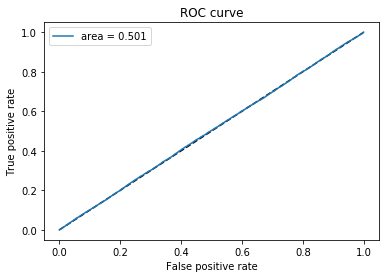

In [91]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_pos_rate, true_pos_rate, label='area = {:.3f}'.format(auc_score))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Submission to Kaggle:

In [0]:
models.best_model_predict(data.test_generator)

In [0]:
# Predictions were made in the order of the test_df using the test generator:
submission = data.test_df
submission['label'] = models.predictions
# Take out the extension for the submission:
submission['id'] = submission['id'].apply(lambda x: x.split(".")[0])

submission.to_csv("submission.csv", index = False, header = True)


In [57]:
submission.head()

,id,label
0,5d8721415d9480961c2d72e63343a64c7f656048,0.075276
1,9527fb2270fe6e386db403ab2a921d2e57ae2d02,0.122981
2,1ae9525a90929a70ce0c91e2d76ad8b9d5fb7c4a,0.064698
3,e812221e6331fc3ba9809c3f86db3579253bc2ab,0.611433
4,c1cc4da4d3e111f63959b1c984ecbb0806879099,0.070948


In [0]:
files.download("submission.csv")

In [59]:
!kaggle competitions submit -c histopathologic-cancer-detection -f submission.csv -m "Message"

100% 2.84M/2.84M [00:07<00:00, 414kB/s]
Successfully submitted to Histopathologic Cancer Detection